# Pairs Trading

_Roshan Mahes (based on the Quantopian Lecture Series)._

As usual, we first import our libraries:

In [91]:
import math
import numpy as np
import pandas as pd

# statistical analysis
import statsmodels.api as sm
from statsmodels import regression
from statsmodels.tsa.stattools import adfuller, coint

# plot + styling
import seaborn
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (10,6)

# get pricing data using Yahoo Finance
from quantopian import get_pricing

# set the seed for the random number generator
np.random.seed(107)

Pairs trading is a classic example of a strategy based on mathematical analysis. The principle is as follows. Let's say you have a pair of securities $X$ and $Y$ that have some underlying economic link. An example might be two companies that manufacture the same product (e.g. PEP (Pepsi) and KO (Coca-Cola)), or two companies in one supply chain. If we can model this economic link with a mathematical model, we can make trades on it.

We'll start by constructing a toy example. We model $X$'s daily returns by drawing from a normal distribution. Then we perform a cumulative sum to get the value of $X$ on each day (we shift all prices up by $50$ to make them positive).

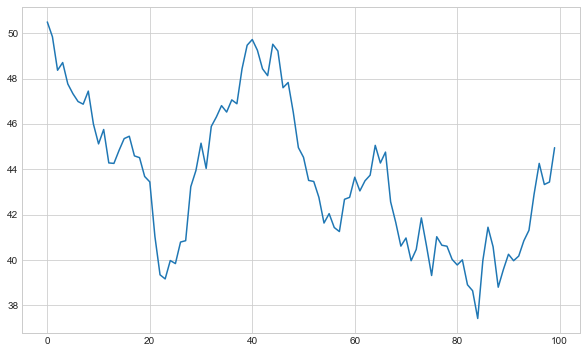

In [45]:
X_returns = np.random.normal(0, 1, 100) # Generate the daily returns
X = pd.Series(np.cumsum(X_returns), name='X') + 50
X.plot();

Now we generate $Y$. As $Y$ is supposed to have a deep economic link to $X$, we model this by taking $X$, shifting it up by $5$ and adding some random noise drawn from a normal distribution.

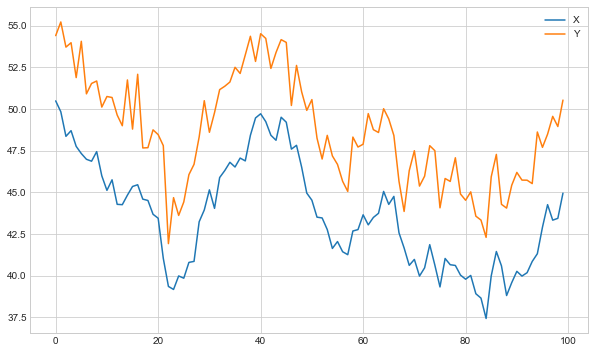

In [46]:
Y = X + 5 + np.random.normal(0, 1, 100)
Y.name = 'Y'
pd.concat([X, Y], axis=1).plot();

## Stationarity

A commonly untested assumption in time series analysis is the stationarity of the data. Many statistical tests, deep down in the fine print of their assumptions, require that the data being tested are stationary. Also, if you naively use certain statistics on a non-stationary data set, you will get garbage results. Data are stationary when the parameters of the data generating process do not change over time. We can  check for stationarity using a statistical test, the so-called _Augmented Dickey-Fuller test:_

In [47]:
def check_for_stationarity(X, cutoff=0.01):
    # H_0 in adfuller if unit root exists (non-stationary)
    # We assume a series to be stationary if the p-value is significant.
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print(f'p-value = {str(pvalue)}. The series is likely stationary.')
        return True
    else:
        print(f'p-value = {str(pvalue)}. The series is likely non-stationary.')
        return False

In [51]:
T = 100

# create two series, one of which is stationary
A = [np.random.normal(0, 1) for t in range(T)]
B = [np.random.normal(0.1 * t, 1) for t in range(T)]

check_for_stationarity(A)
check_for_stationarity(B);

p-value = 4.578310766867489e-21. The series is likely stationary.
p-value = 0.9345674852178903. The series is likely non-stationary.


## Order of Integration

An important concept in time series analysis is _moving average representation_. This representation expresses any time series $Y_t$ as 

\begin{align*}
Y_t = \sum_{j=0}^\infty b_j \epsilon_{t-j} + \eta_t
\end{align*}

* $\epsilon$ is the 'innovation' series;
* $b_j$ are the moving average weights of the innovation series;
* $\eta$ is a deterministic series.

The key here is as follows. $\eta$ is deterministic, such as a sine wave. Therefore we could perfectly model it. The innovation process is stochastic and there to simulate new information occuring over time. Specifically, $\epsilon_t = \hat Y_t - Y_t$ where $\hat Y_t$ is the in the optimal forecast of $Y_t$ using only information from time before $t$. In other words, the best prediction you can make at time $t-1$ cannot account for the randomness in $\epsilon$. Each $b_j$ just says how much previous values of $\epsilon$ influence $Y_t$.


We will note integration order $i$ as $I(i)$. A time series is said to be $I(0)$ if the following condition holds in a moving average representation:

\begin{align*}
\sum_{k=0}^\infty |b_k|^2 < \infty.
\end{align*}

In hand-wavy english, the autocorrelation of the series decays sufficiently quickly. This property turns out to be true of all stationary series, but by itself is not enough for stationarity to hold. This means that stationarity implies $I(0)$, but $I(0)$ does not imply stationarity.

In practice testing whether the sum of the autocorrelations is finite may not be possible. It is possible in a mathematical derivation, but when we have a finite set of data and a finite number of estimated autocorrelations, the sum will always be finite. Given this difficulty, tests for $I(0)$ rely on stationarity implying the property. If we find that a series is stationary, then it must also be $I(0)$.

### Inductively Building Up Orders of Integration

If one takes an $I(0)$ series and cumulatively sums it (_discrete integration_), the new series will be $I(1)$. Notice how this is related to the calculus concept of integration. The same relation applies in general, to get $I(n)$ take an $I(0)$ series and iteratively take the cumulative sum $n$ times. Now let's make an $I(1)$ series by taking the cumulative sum of $A$.

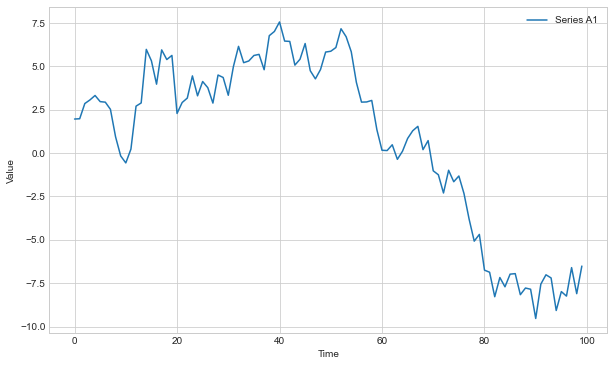

In [52]:
A1 = np.cumsum(A)

plt.plot(A1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A1']);

Now let's make one $I(2)$ by taking the cumlulative sum again.

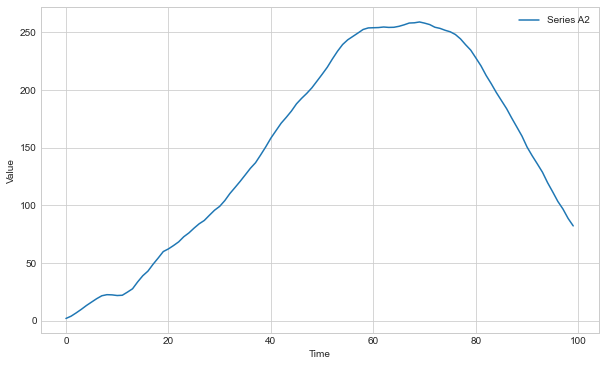

In [53]:
A2 = np.cumsum(A1)

plt.plot(A2)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A2']);

### Breaking Down Orders of Integration

Conversely, to find the order of integration of a given series, we perform the inverse of a cumulative sum, which is the $\Delta$ or _difference operator_. Specifically

\begin{align*}
(1-L) X_t = X_t - X_{t-1} = \Delta X.
\end{align*}

In this case $L$ is the _lag/backshift operator_. $L$ fetches the second to last elements in a time series, and $L^k$ fetches the $k$-th to last elements. So 

\begin{align*}
L X_t = X_{t-1}
\end{align*}

and

\begin{align*}
(1-L) X_t = X_t - X_{t-1}.
\end{align*}

A series $Y_t$ is $I(1)$ if the $Y_t - Y_{t-1}$ is $I(0)$. In other words, if you take an $I(0)$ series and cumulatively sum it, you should get an $I(1)$ series. Once all the math has settled, remember that any stationary series is $I(0)$.

Let's try this out on some real pricing data.

In [64]:
X = get_pricing('MSFT', fields=['price'], start_date='2019-01-01', end_date='2020-01-01')['price']
check_for_stationarity(X);

p-value = 0.8856994110064431. The series is likely non-stationary.


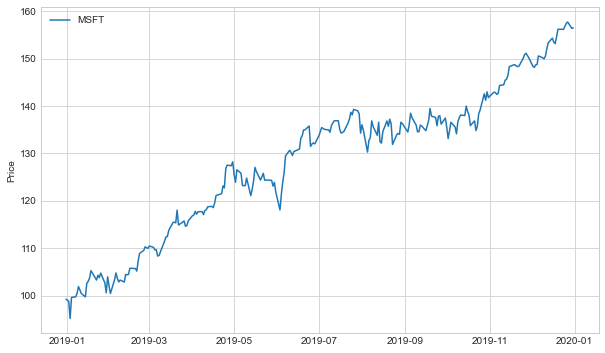

In [67]:
plt.plot(X.index, X.values)
plt.ylabel('Price')
plt.legend(['MSFT']);

Now let's take the delta of the series, giving us the additive returns. We'll check if this is stationary.

p-value = 8.743618179939104e-14. The series is likely stationary.


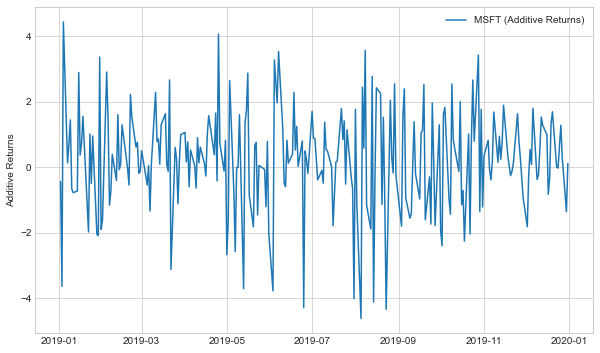

In [77]:
X1 = X.diff()[1:]
check_for_stationarity(X1)
plt.plot(X1)
plt.ylabel('Additive Returns')
plt.legend(['MSFT (Additive Returns)']);

Seems like the additive returns are stationary over 2019. That means we will probably be able to model the returns much better than the price. It also means that the price was $I(1)$. Let's also check the multiplicative returns.

p-value = 8.346930420214613e-14. The series is likely stationary.


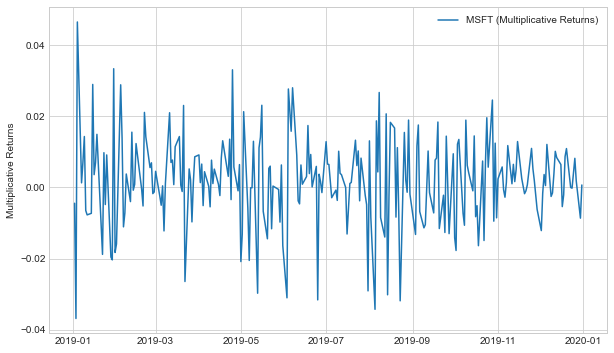

In [76]:
X1 = X.pct_change()[1:]
check_for_stationarity(X1)
plt.plot(X1)
plt.ylabel('Multiplicative Returns')
plt.legend(['MSFT (Multiplicative Returns)']);

It seems like the multiplicative returns are also stationary. Both the multiplicative and additive deltas on a series get at similar pieces of information, so it's not surprising both are stationary. In practice this might not always be the case.

As always, you should not naively assume that because a time series is stationary in the past it will continue to be stationary in the future. Tests for consistency of stationarity such as _cross validation_ and _out of sample testing_ are necessary. This is actually true for any statistical property. Returns may also go in and out of stationarity, and may be stationary or non-stationary depending on the timeframe and sampling frequency. The reason that returns are usually used for modeling in quantitive finance is that they are far more stationary than prices. This makes them easier to model and returns forecasting more feasible. Forecasting prices is more difficult, as there are many trends induced by their $I(1)$ integration. Even using a returns forecasting model to forecast price can be tricky, as any error in the returns forecast will be magnified over time.

## Cointegration

Now that we've discussed stationarity and order of integration, we can discuss _cointegration_. A set of time series $\{X_1,X_2,\dots,X_k\}$ is _cointegrated_ if all series are $I(1)$ and some linear combination of them is $I(0)$.

The intuition here is that for some linear combination of the series, the result lacks much auto-covariance and is mostly noise. This is useful for cases such as pairs trading, in which we find two assets whose prices are cointegrated. Since the linear combination of their prices $b_1A_1 + b_2A_2$ is noise, we can bet on the relationship $b_1A_1 + b_2A_2$ mean reverting and place trades accordingly. Remember as with anything else, you should not assume that because some set of assets have passed a cointegration test historically, they will continue to remain cointegrated. You need to verify that consistent behavior occurs, and use various model validation techniques as you would with any model.

There are a bunch of ways to test for cointegration. In general we're just trying to solve for the coefficients $b_1, \dots b_k$ that will produce an $I(0)$ linear combination. If our best guess for these coefficients does not pass a stationarity check, then we reject the hypothesis that the set is cointegrated. This will lead to risk of Type II errors (false negatives), as we will not exhaustively test for stationarity on all coefficent combinations. However Type II errors are generally okay here, as they are safe and do not lead to us making any wrong forecasts.

In practice a common way to do this for pairs of time series is to use linear regression to estimate $\beta$ in the following model.

\begin{align*}
X_2 = \alpha + \beta X_1 + \epsilon.
\end{align*}

The idea is that if the two are cointegrated we can remove $X_2$'s depedency on $X_1$, leaving behind stationary noise. The combination $X_2 - \beta X_1 = \alpha + \epsilon$ should be stationary.


One of the most important things done in finance is to make many independent bets. Here a quant would find many pairs of assets they hypothesize are cointegrated, and evenly distribute their dollars between them in bets. This only requires more than half of the asset pairs to remain cointegrated for the strategy to work.

### Testing for Cointegration

We've constructed an example of two cointegrated series $X$ and $Y$ before. Let's plot the difference between the two series:

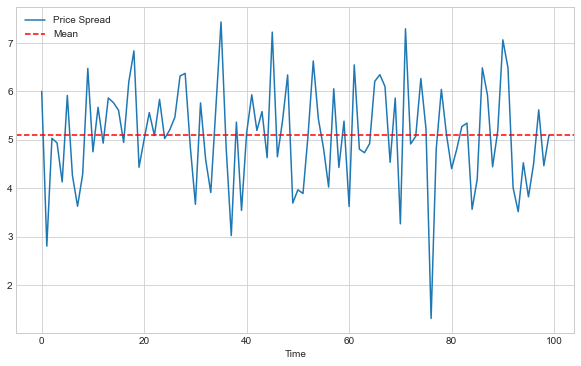

In [80]:
X_returns = np.random.normal(0, 1, 100)
X = pd.Series(np.cumsum(X_returns), name='X') + 50
Y = X + 5 + np.random.normal(0, 1, 100)

(Y - X).plot() # plot the spread
plt.axhline((Y - X).mean(), color='red', linestyle='--') # add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean']);

There is a convenient cointegration test that lives in `statsmodels.tsa.stattools`. Let's say that our confidence level is $0.05$. We should see a p-value below our cutoff, as we've artifically created two series that are the textbook definition of cointegration. Hence, the spread between the two time series is stationary around its mean.

In [83]:
score, pvalue, _ = coint(X,Y)
print(pvalue)

3.418334079455576e-11


## Hedging

Because you'd like to protect yourself from bad markets, often short sales will be used to hedge long investments. Because a short sale makes money if the security sold loses value, and a long purchase will make money if a security gains value, one can long parts of the market and short others. That way if the entire market falls off a cliff, we'll still make money on the shorted securities and hopefully break even. In the case of two securities we'll call it a hedged position when we are long on one security and short on the other.

Because the securities drift towards and apart from each other, there will be times when the distance is high and times when the distance is low. The trick of pairs trading comes from maintaining a hedged position across $X$ and $Y$. If both securities go down, we neither make nor lose money, and likewise if both go up. We make money on the spread of the two reverting to the mean. In order to do this we'll watch for when $X$ and $Y$ are far apart, then short $Y$ and long $X$. Similarly we'll watch for when they're close together, and long $Y$ and short $X$. Recall that the spread is $Y - \beta X$, where $\beta$ is the regression coefficient.

#### Going Long the Spread
This is when the spread is small and we expect it to become larger. We place a bet on this by longing $Y$ and shorting $X$.

#### Going Short the Spread
This is when the spread is large and we expect it to become smaller. We place a bet on this by shorting $Y$ and longing $X$.

One important concept here is that we are placing a bet on one specific thing, and trying to reduce our bet's dependency on other factors such as the market. The best way to find real securities that behave like this is to start with securities you suspect may be cointegrated and perform a statistical test. If you just run statistical tests over all pairs, you'll fall prey to multiple comparison bias.

Here's a method to look through a list of securities and test for cointegration between all pairs. It returns a cointegration test score matrix, a p-value matrix, and any pairs for which the p-value was less than $0.05$.

In [97]:
def find_cointegrated_pairs(data, cutoff=0.05):
    """
    Returns a list of all cointegrated pairs.
    """
    
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    
    keys = data.keys()
    pairs = []
    
    for i in range(n):
        for j in range(i+1, n):
            
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            
            if pvalue < cutoff:
                pairs.append((keys[i], keys[j]))
    
    return score_matrix, pvalue_matrix, pairs

## Looking for Cointegrated Pairs of Alternative Energy Securities
We are looking through a set of solar company stocks to see if any of them are cointegrated. We'll start by defining the list of securities we want to look through. Then we'll get the pricing data for each security for the year of 2014.

Our approach here is somewhere in the middle of the spectrum that we mentioned before. We have formulated an economic hypothesis that there is some sort of link between a subset of securities within the energy sector and we want to test whether there are any cointegrated pairs. This incurs significantly less multiple comparisons bias than searching through hundreds of securities and slightly more than forming a hypothesis for an individual test.

**NOTE:** We include the market in our data. This is because the market drives the movement of so many securities that you often times might find two seemingingly cointegrated securities, but in reality they are not cointegrated and just both cointegrated with the market. This is known as a confounding variable and it is important to check for market involvement in any relationship you find.

In [161]:
symbol_list = ['ABG-P.MC','ASTI','CSOL','DQ','FSLR', 'SPY']
prices_df = get_pricing(symbol_list, fields='price', start_date='2014-01-01', end_date='2015-01-01')
prices_df.head()

,ABG-P.MC,ASTI,CSOL,DQ,FSLR,SPY
Date,,,,,,
2014-01-02,1.9836,146220.0,0.02,38.00,57.44,160.93
2014-01-03,2.0210,145000.0,0.02,39.09,56.74,160.90
2014-01-06,2.0809,142420.0,0.04,40.05,51.26,160.43
2014-01-07,2.1352,145880.0,0.04,41.93,52.49,161.42
2014-01-08,2.0959,142020.0,0.03,42.38,51.68,161.45


Now we'll run our method on the list and see if any pairs are cointegrated.

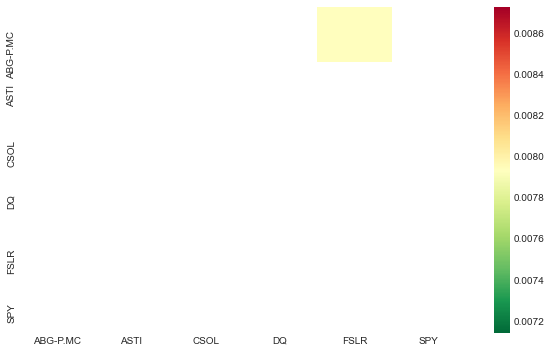

In [162]:
scores, pvalues, pairs = find_cointegrated_pairs(prices_df)
seaborn.heatmap(pvalues, xticklabels=symbol_list, yticklabels=symbol_list, cmap='RdYlGn_r', mask=(pvalues >= 0.05));

Looks like 'ABG-P.MC' and 'FSLR' are cointegrated. Let's take a look at the prices to make sure there's nothing weird going on.

In [163]:
S1 = prices_df['ABG-P.MC']
S2 = prices_df['FSLR']

In [164]:
score, pvalue, _ = coint(S1, S2)
pvalue

0.00793434017033434

## Calculating the Spread
Now we will plot the spread of the two series. In order to actually calculate the spread, we use linear regression to get the coefficient for the linear combination to construct between our two securities. This is known as the Engle-Granger method.

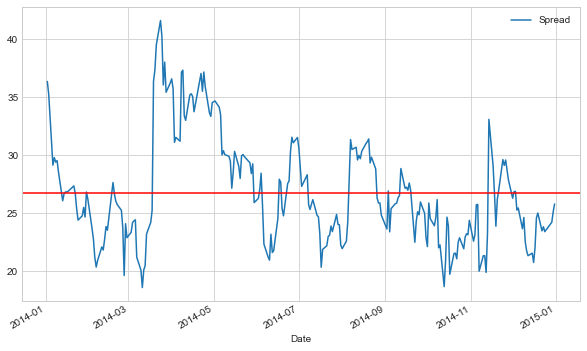

In [165]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['ABG-P.MC']
b = results.params['ABG-P.MC']

spread = S2 - b * S1
spread.plot()
plt.axhline(spread.mean(), color='red')
plt.legend(['Spread']);

Alternatively, we could examine the ratio between the two series.

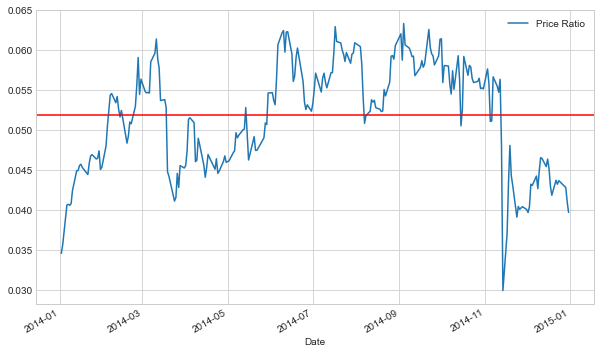

In [166]:
ratio = S1/S2
ratio.plot()
plt.axhline(ratio.mean(), color='red')
plt.legend(['Price Ratio']);

Examining the price ratio of a trading pair is a traditional way to handle pairs trading. Part of why this works as a signal is based in our assumptions of how stock prices move, specifically because stock prices are typically assumed to be log-normally distributed. What this implies is that by taking a ratio of the prices, we are taking a linear combination of the returns associated with them (since prices are just the exponentiated returns).

This can be a little irritating to deal with for our purposes as purchasing the precisely correct ratio of a trading pair may not be practical. We choose instead to move forward with simply calculating the spread between the cointegrated stocks using linear regression. This is a very simple way to handle the relationship, however, and is likely not feasible for non-toy examples. There are other potential methods for estimating the spread, such as the _Kalman filter_.

So, back to our example. The absolute spread isn't very useful in statistical terms. It is more helpful to normalize our signal by treating it as a z-score.

In practice this is usually done to try to give some scale to the data, but this assumes some underlying distribution, usually a normal distribution. Under a normal distribution, we would know that approximately 84% of all spread values will be smaller. However, much financial data is not normally distributed, and one must be very careful not to assume normality, nor any specific distribution when generating statistics. It could be the case that the true distribution of spreads was very fat-tailed and prone to extreme values. This could mess up our model and result in large losses.

In [151]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

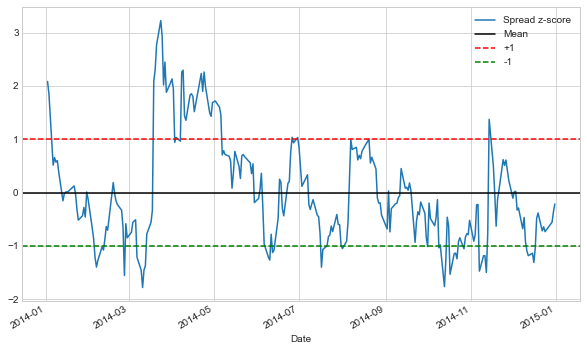

In [152]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

### Simple Strategy:
* Go "Long" the spread whenever the z-score is below -1.0
* Go "Short" the spread when the z-score is above 1.0
* Exit positions when the z-score approaches zero

This is just the tip of the iceberg, and only a very simplistic example to illustrate the concepts.  In practice you would want to compute a more optimal weighting for how many shares to hold for S1 and S2.

## Trading using constantly updating statistics
In general taking a statistic over your whole sample size can be bad. For example, if the market is moving up, and both securities with it, then your average price over the last 3 years may not be representative of today. For this reason traders often use statistics that rely on rolling windows of the most recent data.

## Moving Averages
A moving average is just an average over the last $n$ datapoints for each given time. It will be undefined for the first $n$ datapoints in our series. Shorter moving averages will be more jumpy and less reliable, but respond to new information quickly. Longer moving averages will be smoother, but take more time to incorporate new information.

We also need to use a rolling beta, a rolling estimate of how our spread should be calculated, in order to keep all of our parameters up to date.

In [169]:
from quantopian import RollingOLS

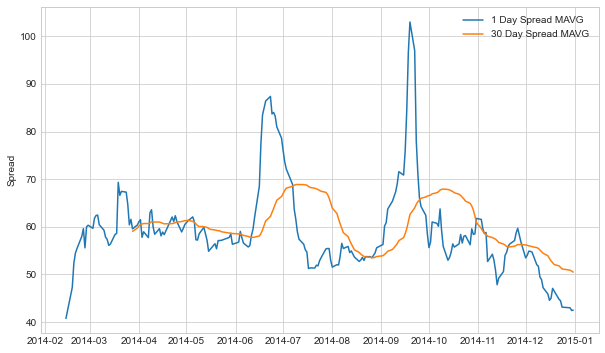

In [178]:
# get the spread between the 2 stocks
# calculate rolling beta coefficient
rolling_beta = RollingOLS(y=S1, x=S2, window=30)
spread = S2 - rolling_beta['x'] * S1

# get the 1 day and 30 day moving average of the price spread
spread_mavg1 = spread.rolling(window=1).mean()
spread_mavg30 = spread.rolling(window=30).mean()

plt.plot(spread_mavg1)
plt.plot(spread_mavg30)

plt.legend(['1 Day Spread MAVG', '30 Day Spread MAVG'])
plt.ylabel('Spread');

We can use the moving averages to compute the z-score of the spread at each given time. This will tell us how extreme the spread is and whether it's a good idea to enter a position at this time. Let's take a look at the z-score now.

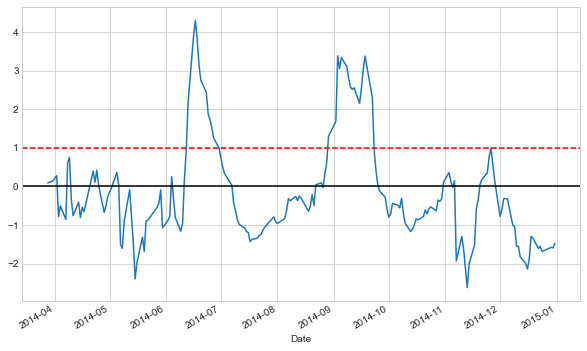

In [180]:
# take a rolling 30 day standard deviation
std_30 = spread.rolling(window=30).std()

# compute the z-score for each day
zscore_30_1 = (spread_mavg1 - spread_mavg30)/std_30
zscore_30_1.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--');

The z-score doesn't mean much out of context, let's plot it next to the prices to get an idea of what it looks like. We'll take the negative of the z-score because the spreads were all negative and that is a little counterintuitive to trade on.

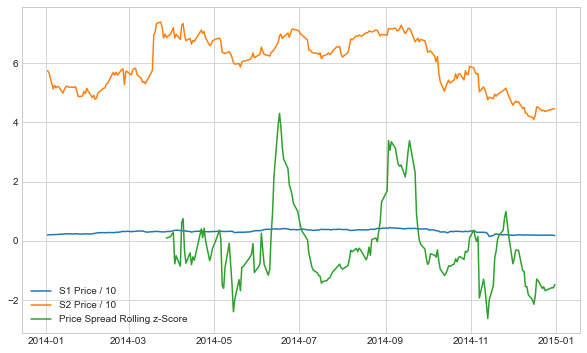

In [183]:
# Plot the prices scaled down along with the negative z-score
# just divide the stock prices by 10 to make viewing it on the plot easier
plt.plot(S1.index, S1.values/10)
plt.plot(S2.index, S2.values/10)
plt.plot(zscore_30_1)
plt.legend(['S1 Price / 10', 'S2 Price / 10', 'Price Spread Rolling z-Score']);

## Out of Sample Test
Now that we have constructed our spread appropriately and have an idea of how we will go about making trades, it is time to conduct some out of sample testing. Our whole model is based on the premise that these securities are cointegrated, but we built it on information from a certain time period. If we actually want to implement this model, we need to conduct an out of sample test to confirm that the principles of our model are still valid going forward.

Since we initially built the model on the 2014 - 2015 year, let's see if this cointegrated relationship holds for 2015 - 2016. Historical results do not guarantee future results so this is a sanity check to see if the work we have done holds strong.

In [184]:
symbol_list = ['ABG-P.MC','FSLR']
prices_df = get_pricing(symbol_list, fields='price', start_date='2015-01-01', end_date='2016-01-01')
prices_df.head()

,ABG-P.MC,FSLR
Date,,
2015-01-02,1.8858,44.55
2015-01-05,1.8250,41.83
2015-01-06,2.0277,40.86
2015-01-07,2.1291,41.75
2015-01-08,2.0760,43.63


In [185]:
S1 = prices_df['ABG-P.MC']
S2 = prices_df['FSLR']

In [186]:
score, pvalue, _ = coint(S1, S2)
print('p-value: ', pvalue)

p-value:  0.9895420757918862


Unfortunately, since our p-value is above the cutoff of $0.05$, we conclude that our model will no longer be valid due to the lack of cointegration between our chosen securities. If we tried to deploy this model without the underlying assumptions holding, we would have no reason to believe that it would actually work. Out of sample testing is a vital step to make sure that our work will actually be viable in the market.

## Implementation
When actually implementing a pairs trading strategy you would normally want to be trading many different pairs at once. If you find a good pair relationship by analyzing data, there is no guarantee that that relationship will continue into the future. Trading many different pairs creates a diversified portfolio to mitigate the risk of individual pairs "falling out of" cointegration.

_This document is based on the Quantiopian Lecture written by Delaney Granizo-Mackenzie and Maxwell Margenot._